라이브러리 로딩 완료!
모든 데이터 파일 로딩 완료!
=== 데이터셋 기본 정보 ===

campaign_desc:
  Shape: (30, 4)
  Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table:
  Shape: (7208, 3)
  Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

causal_data:
  Shape: (36786524, 5)
  Columns: ['PRODUCT_ID', 'STORE_ID', 'WEEK_NO', 'display', 'mailer']

coupon:
  Shape: (124548, 3)
  Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

coupon_redempt:
  Shape: (2318, 4)
  Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']

hh_demographic:
  Shape: (801, 8)
  Columns: ['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC', 'household_key']

product:
  Shape: (92353, 7)
  Columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']

transaction_data:
  Shape: (2595732, 12)
  Columns: ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_V

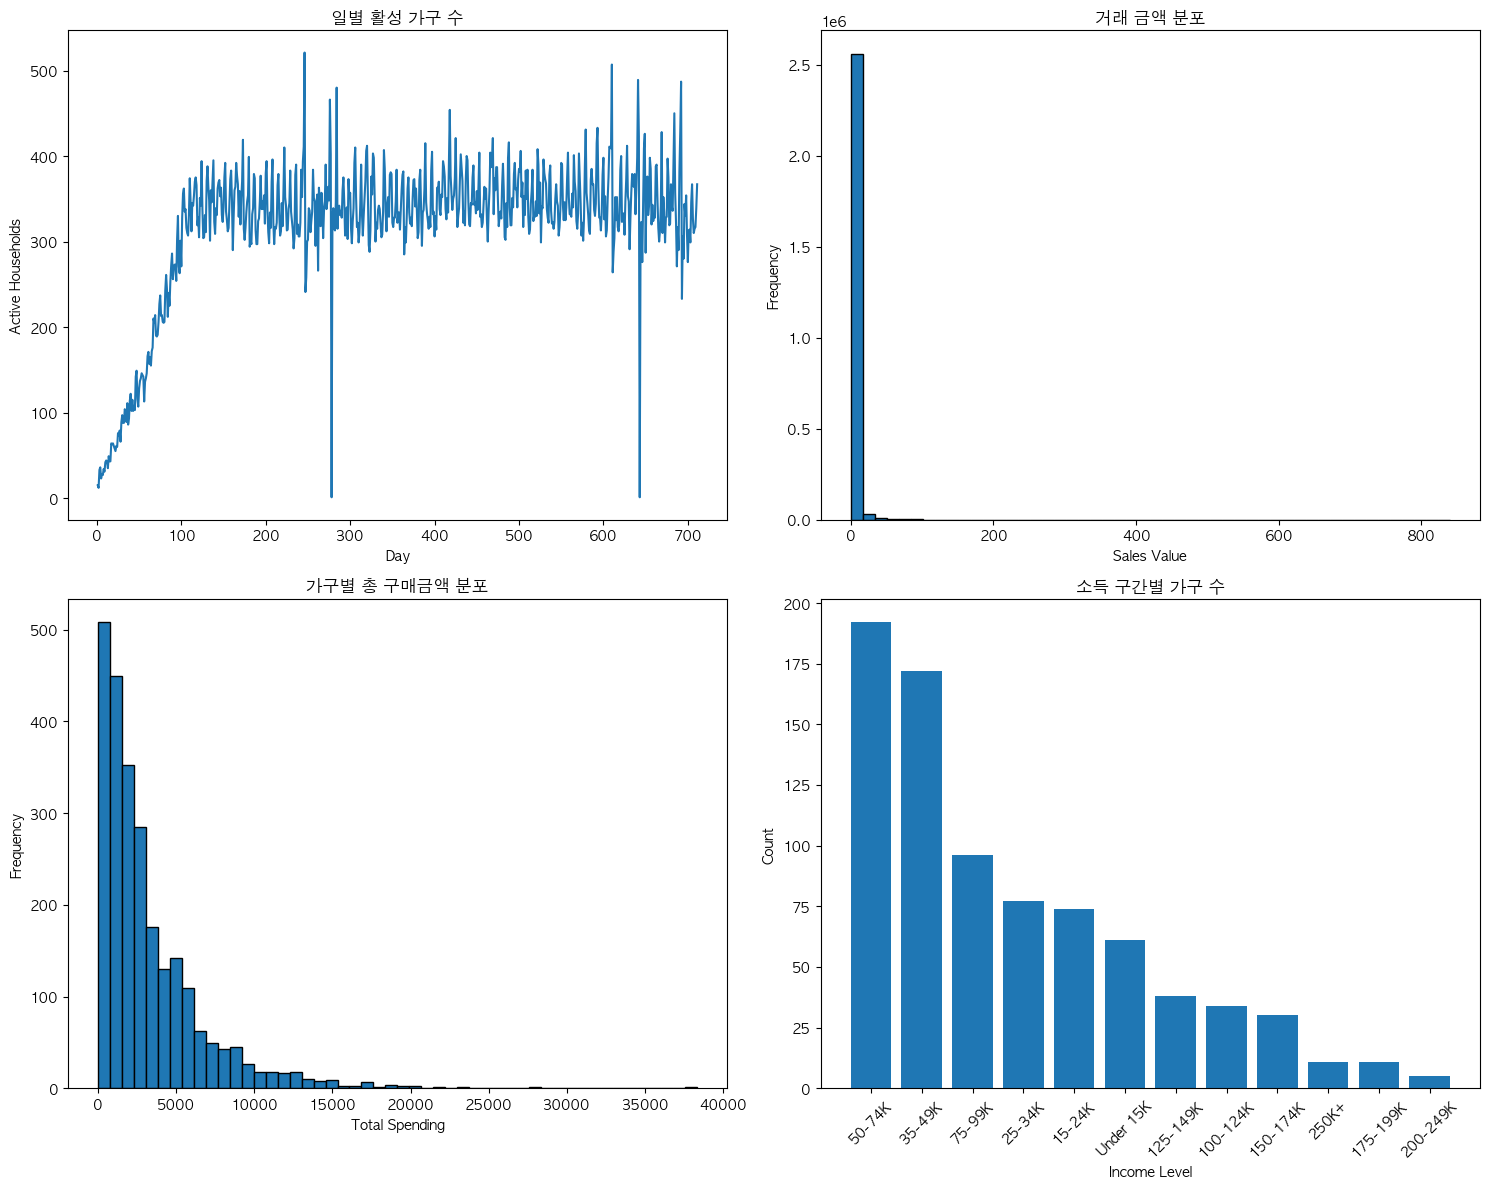

=== 데이터 간 관계 파악 ===
전체 거래 가구: 2500
인구통계 가구: 801
교집합: 801
인구통계 커버리지: 32.0%
캠페인 참여 가구: 1584
=== 데이터 탐색 완료 ===
다음 단계: 데이터 전처리 및 피처 엔지니어링


In [1]:
# %%
# 데이터 탐색 - Dunnhumby Customer Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (맥의 경우)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로딩 완료!")

# %%
# 1. 데이터 로딩
data_path = '../data/raw/'

# 모든 CSV 파일 로딩
campaign_desc = pd.read_csv(f'{data_path}campaign_desc.csv')
campaign_table = pd.read_csv(f'{data_path}campaign_table.csv')
causal_data = pd.read_csv(f'{data_path}causal_data.csv')
coupon = pd.read_csv(f'{data_path}coupon.csv')
coupon_redempt = pd.read_csv(f'{data_path}coupon_redempt.csv')
hh_demographic = pd.read_csv(f'{data_path}hh_demographic.csv')
product = pd.read_csv(f'{data_path}product.csv')
transaction_data = pd.read_csv(f'{data_path}transaction_data.csv')

print("모든 데이터 파일 로딩 완료!")

# %%
# 2. 데이터 기본 정보 확인
datasets = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table, 
    'causal_data': causal_data,
    'coupon': coupon,
    'coupon_redempt': coupon_redempt,
    'hh_demographic': hh_demographic,
    'product': product,
    'transaction_data': transaction_data
}

print("=== 데이터셋 기본 정보 ===")
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")

# %%
# 3. 각 데이터셋 상세 탐색

# 3-1. 거래 데이터 (가장 중요!)
print("=== Transaction Data 상세 분석 ===")
print(f"Shape: {transaction_data.shape}")
print(f"기간: {transaction_data['DAY'].min()} ~ {transaction_data['DAY'].max()}일")
print(f"총 가구 수: {transaction_data['household_key'].nunique()}")
print(f"총 상품 수: {transaction_data['PRODUCT_ID'].nunique()}")

transaction_data.head()

# %%
# 3-2. 인구통계 데이터
print("=== Household Demographics 분석 ===")
print(f"Shape: {hh_demographic.shape}")
print("\n각 컬럼별 고유값:")
for col in hh_demographic.columns:
    if col != 'household_key':
        print(f"{col}: {hh_demographic[col].value_counts().to_dict()}")

hh_demographic.head()

# %%
# 3-3. 상품 데이터
print("=== Product Data 분석 ===")
print(f"Shape: {product.shape}")
print(f"상품 카테고리 수: {product['DEPARTMENT'].nunique()}")
print(f"상위 카테고리:")
print(product['DEPARTMENT'].value_counts().head(10))

product.head()

# %%
# 4. 데이터 품질 체크

print("=== 데이터 품질 체크 ===")

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  결측값: {df.isnull().sum().sum()}")
    print(f"  중복행: {df.duplicated().sum()}")
    
    # 각 컬럼별 결측값
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"  결측값 상세: {dict(missing[missing > 0])}")

# %%
# 5. 기본 통계량 확인

# 5-1. 거래 금액 분포
print("=== 거래 금액 분포 ===")
print("SALES_VALUE 통계:")
print(transaction_data['SALES_VALUE'].describe())

print("\nQUANTITY 통계:")  
print(transaction_data['QUANTITY'].describe())

# %%
# 6. 시각화 - 기본 분포들

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 6-1. 일별 거래량
daily_transactions = transaction_data.groupby('DAY').agg({
    'household_key': 'nunique',
    'SALES_VALUE': 'sum'
}).reset_index()

axes[0,0].plot(daily_transactions['DAY'], daily_transactions['household_key'])
axes[0,0].set_title('일별 활성 가구 수')
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Active Households')

# 6-2. 거래 금액 분포
axes[0,1].hist(transaction_data['SALES_VALUE'], bins=50, edgecolor='black')
axes[0,1].set_title('거래 금액 분포')
axes[0,1].set_xlabel('Sales Value')
axes[0,1].set_ylabel('Frequency')

# 6-3. 가구별 총 구매금액
household_spending = transaction_data.groupby('household_key')['SALES_VALUE'].sum()
axes[1,0].hist(household_spending, bins=50, edgecolor='black')
axes[1,0].set_title('가구별 총 구매금액 분포')
axes[1,0].set_xlabel('Total Spending')
axes[1,0].set_ylabel('Frequency')

# 6-4. 인구통계 - 소득 분포
if 'INCOME_DESC' in hh_demographic.columns:
    income_counts = hh_demographic['INCOME_DESC'].value_counts()
    axes[1,1].bar(range(len(income_counts)), income_counts.values)
    axes[1,1].set_title('소득 구간별 가구 수')
    axes[1,1].set_xlabel('Income Level')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_xticks(range(len(income_counts)))
    axes[1,1].set_xticklabels(income_counts.index, rotation=45)

plt.tight_layout()
plt.show()

# %%
# 7. 데이터 관계 파악

print("=== 데이터 간 관계 파악 ===")

# 7-1. 인구통계가 있는 가구 vs 전체 가구
demo_households = set(hh_demographic['household_key'])
trans_households = set(transaction_data['household_key'])

print(f"전체 거래 가구: {len(trans_households)}")
print(f"인구통계 가구: {len(demo_households)}")
print(f"교집합: {len(demo_households.intersection(trans_households))}")
print(f"인구통계 커버리지: {len(demo_households.intersection(trans_households))/len(trans_households)*100:.1f}%")

# 7-2. 캠페인 참여 가구
campaign_households = set(campaign_table['household_key']) if not campaign_table.empty else set()
print(f"캠페인 참여 가구: {len(campaign_households)}")

# %%
print("=== 데이터 탐색 완료 ===")
print("다음 단계: 데이터 전처리 및 피처 엔지니어링")

In [2]:
# 쿠폰 데이터의 중복 확인
print("=== 쿠폰 데이터 중복 분석 ===")
print(f"전체 행 수: {len(coupon)}")
print(f"중복 행 수: {coupon.duplicated().sum()}")
print(f"고유 행 수: {len(coupon.drop_duplicates())}")

# 중복된 행들 살펴보기
print("\n중복된 행 예시:")
duplicated_rows = coupon[coupon.duplicated(keep=False)]
print(duplicated_rows.head(10))

# 각 컬럼별로 체크해보기
print("\n각 컬럼 조합별 중복 체크:")
print("COUPON_UPC 중복:", coupon['COUPON_UPC'].duplicated().sum())
print("PRODUCT_ID 중복:", coupon['PRODUCT_ID'].duplicated().sum()) 
print("CAMPAIGN 중복:", coupon['CAMPAIGN'].duplicated().sum())

# 실제 비즈니스 로직 관점에서 중복인지 확인
print("\n=== 비즈니스 관점 중복 분석 ===")
# 같은 쿠폰이 같은 상품에 여러 캠페인에서 사용될 수 있나?
print("(COUPON_UPC, PRODUCT_ID) 조합 중복:")
print(coupon.groupby(['COUPON_UPC', 'PRODUCT_ID']).size().sort_values(ascending=False).head())

=== 쿠폰 데이터 중복 분석 ===
전체 행 수: 124548
중복 행 수: 5164
고유 행 수: 119384

중복된 행 예시:
      COUPON_UPC  PRODUCT_ID  CAMPAIGN
47   54100010032       34214        27
49   54100010032       34214        27
50   54100010032       34214        27
51   54100010032       34214        27
124  54589314175       48728        27
126  54589314175       48728        27
127  54589314187       48728        27
128  54589314187       48728        27
129  54589314187       48728        27
130  54589314187       48728        27

각 컬럼 조합별 중복 체크:
COUPON_UPC 중복: 123413
PRODUCT_ID 중복: 80415
CAMPAIGN 중복: 124518

=== 비즈니스 관점 중복 분석 ===
(COUPON_UPC, PRODUCT_ID) 조합 중복:
COUPON_UPC   PRODUCT_ID
57940011075  921912        19
57940011080  921912        19
57940018081  6704447       17
51111131075  1065098       17
54100027032  1118641       17
dtype: int64


In [3]:
# %%
# 모든 데이터셋의 중복 상세 분석

print("=== 모든 데이터셋 중복 상세 분석 ===\n")

datasets_to_check = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table, 
    'causal_data': causal_data,
    'coupon_redempt': coupon_redempt,
    'hh_demographic': hh_demographic,
    'product': product,
    'transaction_data': transaction_data
}

for name, df in datasets_to_check.items():
    print(f"=== {name} ===")
    print(f"전체 행 수: {len(df):,}")
    print(f"중복 행 수: {df.duplicated().sum():,}")
    print(f"고유 행 수: {len(df.drop_duplicates()):,}")
    
    if df.duplicated().sum() > 0:
        print("⚠️ 중복 발견! 중복된 행 예시:")
        duplicated_rows = df[df.duplicated(keep=False)].head(5)
        print(duplicated_rows)
        print()
    else:
        print("✅ 중복 없음")
    print("-" * 50)

# %%
# 가장 큰 데이터인 causal_data 별도 확인 (메모리 고려)
print("=== causal_data 상세 분석 (큰 데이터) ===")
print(f"전체 행 수: {len(causal_data):,}")

# 샘플로 확인 (메모리 절약)
sample_size = 100000
causal_sample = causal_data.sample(n=sample_size, random_state=42)
sample_duplicates = causal_sample.duplicated().sum()

print(f"샘플 {sample_size:,}개 중 중복: {sample_duplicates}")
print(f"추정 전체 중복 비율: {sample_duplicates/sample_size*100:.2f}%")

if sample_duplicates > 0:
    print("샘플에서 발견된 중복 예시:")
    dup_sample = causal_sample[causal_sample.duplicated(keep=False)].head()
    print(dup_sample)

# %%
# transaction_data 특별 확인 (가장 중요한 데이터)
print("=== transaction_data 상세 분석 ===")

# 비즈니스 키 조합별 중복 확인
print("비즈니스 키 조합 중복 확인:")
print("1. (household_key, DAY, PRODUCT_ID) 조합 중복:")
business_key_dups = transaction_data.groupby(['household_key', 'DAY', 'PRODUCT_ID']).size()
multiple_transactions = business_key_dups[business_key_dups > 1]
print(f"같은 날 같은 가구가 같은 상품을 여러 번 구매: {len(multiple_transactions)}건")

if len(multiple_transactions) > 0:
    print("예시 (같은 날 같은 상품 여러 구매):")
    sample_key = multiple_transactions.head(1).index[0]
    sample_transactions = transaction_data[
        (transaction_data['household_key'] == sample_key[0]) & 
        (transaction_data['DAY'] == sample_key[1]) & 
        (transaction_data['PRODUCT_ID'] == sample_key[2])
    ]
    print(sample_transactions[['household_key', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'BASKET_ID']])

# %%
print("=== 중복 분석 요약 ===")
print("완전 중복 (모든 컬럼 동일) 발견된 데이터셋:")
for name, df in datasets_to_check.items():
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"- {name}: {dup_count:,}개")
        
print(f"- coupon: {coupon.duplicated().sum():,}개")

=== 모든 데이터셋 중복 상세 분석 ===

=== campaign_desc ===
전체 행 수: 30
중복 행 수: 0
고유 행 수: 30
✅ 중복 없음
--------------------------------------------------
=== campaign_table ===
전체 행 수: 7,208
중복 행 수: 0
고유 행 수: 7,208
✅ 중복 없음
--------------------------------------------------
=== causal_data ===
전체 행 수: 36,786,524
중복 행 수: 0
고유 행 수: 36,786,524
✅ 중복 없음
--------------------------------------------------
=== coupon_redempt ===
전체 행 수: 2,318
중복 행 수: 0
고유 행 수: 2,318
✅ 중복 없음
--------------------------------------------------
=== hh_demographic ===
전체 행 수: 801
중복 행 수: 0
고유 행 수: 801
✅ 중복 없음
--------------------------------------------------
=== product ===
전체 행 수: 92,353
중복 행 수: 0
고유 행 수: 92,353
✅ 중복 없음
--------------------------------------------------
=== transaction_data ===
전체 행 수: 2,595,732
중복 행 수: 0
고유 행 수: 2,595,732
✅ 중복 없음
--------------------------------------------------
=== causal_data 상세 분석 (큰 데이터) ===
전체 행 수: 36,786,524
샘플 100,000개 중 중복: 0
추정 전체 중복 비율: 0.00%
=== transaction_data 상세 분석 ===
비즈니스 키 조합 

In [4]:
# 1. coupon 중복 제거 (확실)
coupon_clean = coupon.drop_duplicates()
print(f"coupon 중복 제거: {len(coupon)} → {len(coupon_clean)}")

# 2. transaction_data의 0달러 거래 확인
zero_transactions = transaction_data[transaction_data['SALES_VALUE'] == 0]
print(f"0달러 거래 건수: {len(zero_transactions)}")
print("0달러 거래 예시:")
print(zero_transactions[['household_key', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE']].head())

coupon 중복 제거: 124548 → 119384
0달러 거래 건수: 18850
0달러 거래 예시:
     household_key  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE
97             744    1     5978648         0          0.0
128           1287    1     5978648         0          0.0
249           2305    2     5978656         0          0.0
293            271    2     5978656         0          0.0
694            315    3      957951         0          0.0


In [5]:
# 0달러 거래 상세 분석
print("=== 0달러 거래 상세 분석 ===")
zero_trans = transaction_data[transaction_data['SALES_VALUE'] == 0]

print("QUANTITY 분포:")
print(zero_trans['QUANTITY'].value_counts().head(10))

print("\n할인 정보:")
print("RETAIL_DISC 통계:", zero_trans['RETAIL_DISC'].describe())
print("COUPON_DISC 통계:", zero_trans['COUPON_DISC'].describe())

print("\n0달러 거래 중 할인이 있는 경우:")
discounted = zero_trans[(zero_trans['RETAIL_DISC'] != 0) | (zero_trans['COUPON_DISC'] != 0)]
print(f"할인 적용된 0달러 거래: {len(discounted)}건")

=== 0달러 거래 상세 분석 ===
QUANTITY 분포:
QUANTITY
0    14399
1     4370
2       75
3        5
9        1
Name: count, dtype: int64

할인 정보:
RETAIL_DISC 통계: count    18850.000000
mean        -0.781153
std          1.816268
min        -39.950000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.010000
Name: RETAIL_DISC, dtype: float64
COUPON_DISC 통계: count    18850.000000
mean        -0.550489
std          1.505729
min        -37.930000
25%         -0.500000
50%          0.000000
75%          0.000000
max          0.000000
Name: COUPON_DISC, dtype: float64

0달러 거래 중 할인이 있는 경우:
할인 적용된 0달러 거래: 8729건


In [6]:
# 데이터 정제 전략
print("=== 데이터 정제 전략 ===")

# 1. 취소/환불 거래 (QUANTITY = 0) 제거
cancellation_trans = transaction_data[transaction_data['QUANTITY'] == 0]
print(f"취소/환불 거래 제거 대상: {len(cancellation_trans):,}건")

# 2. 정상 거래만 필터링
clean_transactions = transaction_data[
    (transaction_data['QUANTITY'] > 0) & 
    (transaction_data['SALES_VALUE'] >= 0)
]
print(f"정제 후 거래 데이터: {len(clean_transactions):,}건")
print(f"제거된 거래: {len(transaction_data) - len(clean_transactions):,}건")

# 3. 무료 상품도 포함 (SALES_VALUE = 0, QUANTITY > 0)
free_products = clean_transactions[clean_transactions['SALES_VALUE'] == 0]
print(f"무료 상품 거래 (유지): {len(free_products):,}건")

=== 데이터 정제 전략 ===
취소/환불 거래 제거 대상: 14,466건
정제 후 거래 데이터: 2,581,266건
제거된 거래: 14,466건
무료 상품 거래 (유지): 4,451건
